In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from ISLP import load_data

In [2]:
from scipy.stats import \
(ttest_1samp ,
ttest_rel ,
ttest_ind ,
t as t_dbn)
from statsmodels.stats.multicomp import \
pairwise_tukeyhsd
from statsmodels.stats.multitest import \
multipletests as mult_test

# 13.6.1 Review of Hypothesis Tests

In [3]:
rng = np.random.default_rng (12)
X = rng.standard_normal((10, 100))
true_mean = np.array ([0.5]*50 + [0]*50)
X += true_mean[None,:]

In [4]:
result = ttest_1samp(X[:,0], 0)
result.pvalue

0.9307442156164141

In [5]:
p_values = np.empty(100)
for i in range(100):
    p_values[i] = ttest_1samp(X[:,i], 0).pvalue
decision = pd.cut(p_values ,
                [0, 0.05, 1],
                labels=['Reject H0',
                    'Do not reject H0'])
truth = pd.Categorical(true_mean == 0,
                        categories=[True , False],
                        ordered=True)

In [6]:
pd.crosstab(decision ,
            truth ,
            rownames=['Decision'],
            colnames=['H0'])

H0,True,False
Decision,,
Reject H0,5,15
Do not reject H0,45,35


In [7]:
true_mean = np.array ([1]*50 + [0]*50)
X = rng.standard_normal((10, 100))
X += true_mean[None,:]
for i in range(100):
    p_values[i] = ttest_1samp(X[:,i], 0).pvalue
decision = pd.cut(p_values ,
                [0, 0.05, 1],
                labels=['Reject H0',
                        'Do not reject H0'])
truth = pd.Categorical(true_mean == 0,
                        categories=[True , False],
                        ordered=True)
pd.crosstab(decision ,
            truth ,
            rownames=['Decision'],
            colnames=['H0'])

H0,True,False
Decision,,
Reject H0,2,40
Do not reject H0,48,10


# 13.6.2 Family-Wise Error Rate

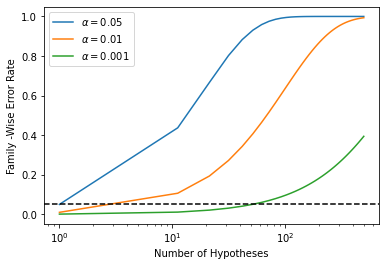

In [8]:
m = np.linspace(1, 501)
fig , ax = plt.subplots()
[ax.plot(m,
        1 - (1 - alpha)**m,
        label=r'$\alpha=%s$' % str(alpha))
        for alpha in [0.05, 0.01, 0.001]]
ax.set_xscale('log')
ax.set_xlabel('Number of Hypotheses')
ax.set_ylabel('Family -Wise Error Rate')
ax.legend()
ax.axhline(0.05, c='k', ls='--');

In [9]:
Fund = load_data('Fund')
fund_mini = Fund.iloc[:,:5]
fund_mini_pvals = np.empty(5)
for i in range(5):
    fund_mini_pvals[i] = ttest_1samp(fund_mini.iloc[:,i], 0).pvalue
fund_mini_pvals

array([0.00620236, 0.91827115, 0.01160098, 0.6005396 , 0.75578151])

In [10]:
reject , bonf = mult_test(fund_mini_pvals , method = "bonferroni")[:2]
reject

array([ True, False, False, False, False])

In [11]:
bonf , np.minimum(fund_mini_pvals * 5, 1)

(array([0.03101178, 1.        , 0.05800491, 1.        , 1.        ]),
 array([0.03101178, 1.        , 0.05800491, 1.        , 1.        ]))

In [12]:
mult_test(fund_mini_pvals , method = "holm", alpha=0.05)[:2]

(array([ True, False,  True, False, False]),
 array([0.03101178, 1.        , 0.04640393, 1.        , 1.        ]))

In [13]:
fund_mini.mean()

Manager1    3.0
Manager2   -0.1
Manager3    2.8
Manager4    0.5
Manager5    0.3
dtype: float64

In [14]:
ttest_rel(fund_mini['Manager1'],
          fund_mini['Manager2']).pvalue

0.038391072368079586

In [15]:
returns = np.hstack([fund_mini.iloc[:,i] for i in range(5)])
managers = np.hstack([[i+1]*50 for i in range(5)])
tukey = pairwise_tukeyhsd(returns , managers)
print(tukey.summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2     -3.1 0.1862 -6.9865 0.7865  False
     1      3     -0.2 0.9999 -4.0865 3.6865  False
     1      4     -2.5 0.3948 -6.3865 1.3865  False
     1      5     -2.7 0.3152 -6.5865 1.1865  False
     2      3      2.9 0.2453 -0.9865 6.7865  False
     2      4      0.6 0.9932 -3.2865 4.4865  False
     2      5      0.4 0.9986 -3.4865 4.2865  False
     3      4     -2.3  0.482 -6.1865 1.5865  False
     3      5     -2.5 0.3948 -6.3865 1.3865  False
     4      5     -0.2 0.9999 -4.0865 3.6865  False
---------------------------------------------------


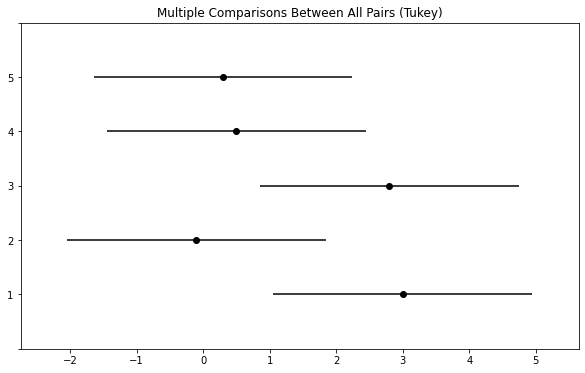

In [16]:
fig , ax = plt.subplots(figsize=(8,8))
tukey.plot_simultaneous(ax=ax);

# 13.6.3 False Discovery Rate

In [17]:
fund_pvalues = np.empty (2000)
for i, manager in enumerate(Fund.columns):
    fund_pvalues[i] = ttest_1samp(Fund[manager], 0).pvalue

In [18]:
fund_qvalues = mult_test(fund_pvalues , method = "fdr_bh")[1]
fund_qvalues [:10]

array([0.08988921, 0.991491  , 0.12211561, 0.92342997, 0.95603587,
       0.07513802, 0.0767015 , 0.07513802, 0.07513802, 0.07513802])

In [19]:
(fund_qvalues <= 0.1).sum()

146

In [20]:
(fund_pvalues <= 0.1 / 2000).sum()

0

In [22]:
sorted_ = np.sort(fund_pvalues)
m = fund_pvalues.shape[0]
q = 0.1
sorted_set_ = np.where(sorted_ < q * np.linspace(1, m, m) / m)[0]
if sorted_set_.shape[0] > 0:
    selected_ = fund_pvalues < sorted_[sorted_set_].max()
    sorted_set_ = np.arange(sorted_set_.max())
else:
    selected_ = []
    sorted_set_ = []

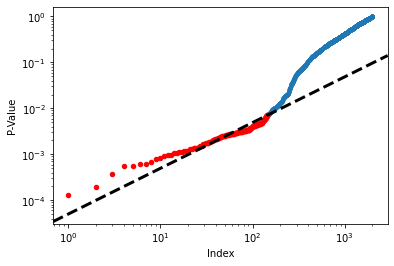

In [23]:
fig , ax = plt.subplots()
ax.scatter(np.arange(0, sorted_.shape[0]) + 1,
           sorted_ , s=10)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('P-Value')
ax.set_xlabel('Index')
ax.scatter(sorted_set_+1, sorted_[sorted_set_], c='r', s=20)
ax.axline((0, 0), (1,q/m), c='k', ls='--', linewidth=3);

# 13.6.4 A Re-Sampling Approach

In [24]:
Khan = load_data('Khan')
D = pd.concat([Khan['xtrain'], Khan['xtest']])
D['Y'] = pd.concat([Khan['ytrain'], Khan['ytest']])
D['Y'].value_counts()

2    29
4    25
3    18
1    11
Name: Y, dtype: int64

In [25]:
D2 = D[lambda df:df['Y'] == 2]
D4 = D[lambda df:df['Y'] == 4]
gene_11 = 'G0011'
observedT , pvalue = ttest_ind(D2[gene_11],
                                D4[gene_11],
                                equal_var=True)
observedT , pvalue

(-2.0936330736768185, 0.04118643782678394)

In [26]:
B = 10000
Tnull = np.empty(B)
D_ = np.hstack([D2[gene_11], D4[gene_11]])
n_ = D2[gene_11].shape[0]
D_null = D_.copy()
for b in range(B):
    rng.shuffle(D_null)
    ttest_ = ttest_ind(D_null[:n_],
                        D_null[n_:],
                        equal_var=True)
    Tnull[b] = ttest_.statistic
(np.abs(Tnull) > np.abs(observedT)).mean()

0.0398

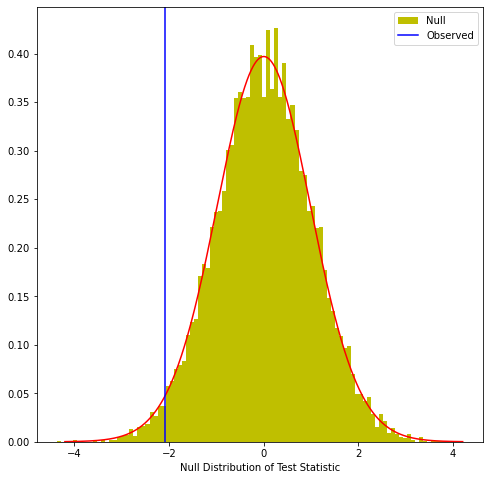

In [27]:
fig , ax = plt.subplots(figsize=(8,8))
ax.hist(Tnull ,
        bins=100,
        density=True ,
        facecolor='y',
        label='Null')
xval = np.linspace(-4.2, 4.2, 1001)
ax.plot(xval ,
        t_dbn.pdf(xval , D_.shape[0]-2),
        c='r')
ax.axvline(observedT ,
            c='b',
            label='Observed')
ax.legend()
ax.set_xlabel("Null Distribution of Test Statistic");

In [30]:
m, B = 100, 500
idx = rng.choice(Khan['xtest'].columns , m, replace=False)
T_vals = np.empty(m)
Tnull_vals = np.empty((m, B))

for j in range(m):
    col = idx[j]
    T_vals[j] = ttest_ind(D2[col],
                            D4[col],
                            equal_var=True).statistic
    D_ = np.hstack([D2[col], D4[col]])
    D_null = D_.copy()
    for b in range(B):
        rng.shuffle(D_null)
        ttest_ = ttest_ind(D_null[:n_],
                            D_null[n_:],
                            equal_var=True)
        Tnull_vals[j,b] = ttest_.statistic

In [31]:
cutoffs = np.sort(np.abs(T_vals))
FDRs , Rs, Vs = np.empty((3, m))
for j in range(m):
    R = np.sum(np.abs(T_vals) >= cutoffs[j])
    V = np.sum(np.abs(Tnull_vals) >= cutoffs[j]) / B
    Rs[j] = R
    Vs[j] = V
    FDRs[j] = V / R

In [32]:
sorted(idx[np.abs(T_vals) >= cutoffs[FDRs < 0.1].min()])

['G0501',
 'G0533',
 'G0566',
 'G0694',
 'G0797',
 'G1049',
 'G1201',
 'G1204',
 'G1220',
 'G1287',
 'G1297',
 'G1331',
 'G1416',
 'G1606',
 'G1645',
 'G1671',
 'G1778',
 'G1931',
 'G2017',
 'G2021',
 'G2080',
 'G2148',
 'G2149']

In [33]:
sorted(idx[np.abs(T_vals) >= cutoffs[FDRs < 0.2].min()])

['G0109',
 'G0242',
 'G0399',
 'G0501',
 'G0533',
 'G0566',
 'G0582',
 'G0608',
 'G0694',
 'G0797',
 'G0861',
 'G0887',
 'G1049',
 'G1162',
 'G1201',
 'G1204',
 'G1220',
 'G1285',
 'G1287',
 'G1297',
 'G1305',
 'G1331',
 'G1416',
 'G1606',
 'G1645',
 'G1671',
 'G1778',
 'G1782',
 'G1876',
 'G1931',
 'G2017',
 'G2021',
 'G2080',
 'G2148',
 'G2149']

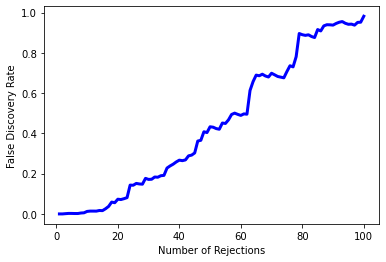

In [34]:
fig , ax = plt.subplots()
ax.plot(Rs, FDRs , 'b', linewidth=3)
ax.set_xlabel("Number of Rejections")
ax.set_ylabel("False Discovery Rate");